In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Sequential, ModuleList
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import global_mean_pool

from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split

- MPNNLayer class defines a single message passing layer, inheriting from torch_geometric.nn.MessagePassing. It applies a linear transformation to the input node features and then performs message passing.
- forward method of MPNNLayer adds self-loops to the adjacency matrix, linearly transforms the input node features, and then starts propagating messages using the propagate method.
- message method of MPNNLayer normalizes node features and multiplies them with the corresponding adjacency weights.
- update method of MPNNLayer returns the new node embeddings after aggregation.
- MPNN class serves as a container for multiple MPNNLayer instances, similar to the GCN class. It iterates over the layers, applies them sequentially, and then applies a final MLP for prediction.

In [12]:
class MPNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, dropout, nbr_classes):
        super(MPNN, self).__init__()
        self.nbr_classes = nbr_classes
        self.convs = torch.nn.ModuleList()
        self.convs.append(MPNNLayer(in_channels, hidden_channels))
        for _ in range(num_layers - 1):
            self.convs.append(MPNNLayer(hidden_channels, hidden_channels))
        self.mlp = torch.nn.Sequential(Linear(hidden_channels, hidden_channels), ReLU(), Linear(hidden_channels, 1))
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            if self.dropout > 0:
                x = F.dropout(x, p=self.dropout, training=self.training)
        x = global_mean_pool(x, batch)
        x = self.mlp(x)
        if self.nbr_classes > 2:
            return F.log_softmax(x, dim=1)
        else:
            return F.sigmoid(x)

class MPNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(MPNNLayer, self).__init__(aggr='mean')
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Start propagating messages.
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

    def message(self, x_j, edge_index, size):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        row, col = edge_index
        deg = degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]

        # Step 5: Return new node embeddings.
        return aggr_out


In [14]:
# Some cells from the Graph_Building ipynb because I didn't manage to save the dataset in a way that I could use it in another notebook

from torch_geometric.data import InMemoryDataset
from torch_geometric.utils import from_networkx

import networkx as nx
from networkx.convert_matrix import from_numpy_array

# Creating a dictionary of lists of paths to the correlation matrices for each method. Each list in the dictionary represents a different method.
methods = ['pearson', 'spearman', 'kendall', 'partial']
full_corr_path_lists = {}
for method in methods:
    method_dir = f'ADNI_full/corr_matrices/corr_matrix_{method}/'
    full_corr_path_lists[method] = []
    for file in os.listdir(method_dir):
        full_corr_path_lists[method].append(file)
# Generating the diagnostic file from the diagnostic_label.csv file
diagnostic_label = np.loadtxt('ADNI_full/diagnostic_label.csv', dtype=str, delimiter=',')

# Combining the 'EMCI', 'LMCI' and 'MCI' diagnostics into a single 'MCI' label for simplicity, then one-hot encoding the diagnostics
for patient in range(len(diagnostic_label)):
    if diagnostic_label[patient] == 'CN':
        diagnostic_label[patient] = 0
    elif diagnostic_label[patient] == 'SMC':
        diagnostic_label[patient] = 1
    elif diagnostic_label[patient] == 'EMCI' or diagnostic_label[patient] == 'LMCI' or diagnostic_label[patient] == 'MCI':
        diagnostic_label[patient] = 2
    elif diagnostic_label[patient] == 'AD':
        diagnostic_label[patient] = 3
    else:
        print('Error: Diagnostic label not recognised')
        break

# Loading the age feature of patients to use as a node feature
ages = np.loadtxt('ADNI_full/age.csv', delimiter=',')
min_age = np.min(ages)
max_age = np.max(ages)

# Prepocessing the sex feature of patients to use as a node feature. Here, 0 represents male patients and 1 represents female patients
sex = np.loadtxt('ADNI_full/sex.csv', dtype=str, delimiter=',')
for patient in range(len(sex)):
    if sex[patient] == 'M':
        sex[patient] = 0
    else:
        sex[patient] = 1

# Defining functions to simplify the code in the class Raw_to_Graph.
# To convert a dictionnary into a numpy array
def dict_to_array(dict):
    array = np.array(list(dict.values()))
    return array

# To normalize an array
def normalize_array(array):
    norm_array = (array - np.mean(array)) / np.std(array)
    return norm_array

# Functions to implement the matrix profile algorithm using STUMPY++. 
## This is commented out as my local kernel dies when running this cell because of memory issues with matrix profiling. I acquired the data by running it on colab and saving it in the repo here. Only uncomment if needed.

# # Computing the matrix profile using STUMPY++
# def compute_matrix_profile(time_series, m=3):
#     # Here the m parameter is the window size, i.e. the length of the subsequence to compute the matrix profile for. 
#     # Are we looking for short-lived neural activations (then small m), or are we interested in detecting longer-term changes or anomalies in brain activity (large m).
#     matrix_profile, idx = stump(time_series, m)
#     return matrix_profile, idx

# # Finding the motif and discord in the matrix profile
# def find_motif_discord(matrix_profile, idx):
#     motif_idx = np.argmin(matrix_profile)
#     discord_idx = np.argmax(matrix_profile)
#     motif = idx[motif_idx]
#     discord = idx[discord_idx]
#     return motif, discord

# # Function to compute the matrix profile, motifs and discords for a correlation matrix
# def matrix_profile(corr_matrix):
#     matrix_profiles = []
#     motifs = []
#     discords = []
#     for row in corr_matrix:
#         mp, idx = compute_matrix_profile(row)
#         matrix_profiles.append(mp)
#         motif, discord = find_motif_discord(mp, idx)
#         motifs.append(motif)
#         discords.append(discord)
#     motifs_array = np.array(motifs)
#     discords_array = np.array(discords)
#     return matrix_profiles, motifs_array, discords_array

# # Computing the matrix profiles for all the correlation matrices we have and saving them in a folder
# for method in methods:
#     method_dir = f'ADNI_full/corr_matrices/corr_matrix_{method}/'
#     for file in os.listdir(method_dir):
#         corr_matrix = np.loadtxt(method_dir + file, delimiter=',')
#         matrix_profiles, motifs, discords = matrix_profile(corr_matrix)
#         np.savetxt(f'ADNI_full/matrix_profiles/matrix_profile_{method}/{file}', matrix_profiles, delimiter=',')
#         np.savetxt(f'ADNI_full/motifs/motifs_{method}/{file}', motifs, delimiter=',')
#         np.savetxt(f'ADNI_full/discords/discords_{method}/{file}', discords, delimiter=',')

# Defining a class to preprocess raw data into a format suitable for training Graph Neural Networks (GNNs).
## With the possibility of assigning weight to edges, adding the age feature, sex feature, and matrixe profiling.

class Raw_to_Graph(InMemoryDataset):
    def __init__(self, root, threshold, method, weight=False, age=False, sex=False, matrixprofile=False, transform=None, pre_transform=None):
        self.threshold = threshold
        self.method = method
        self.weight = weight
        self.age = age
        self.sex = sex
        self.matrixprofile = matrixprofile
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return ['data.pt']

    # This function is used to process the raw data into a format suitable for GNNs, by constructing graphs out of the connectivity matrices.
    def process(self):
        graphs=[]
        corr_matrices = full_corr_path_lists[self.method]
        for patient_idx, patient_matrix in enumerate(corr_matrices):
            path = f'ADNI_full/corr_matrices/corr_matrix_{self.method}/{patient_matrix}'
            corr_matrix = pd.read_csv(path, header=None).values
            # Here ROIs stands for Regions of Interest
            nbr_ROIs = corr_matrix.shape[0]
            edge_matrix = np.zeros((nbr_ROIs,nbr_ROIs))
            for j in range(nbr_ROIs):
                for k in range(nbr_ROIs):
                    # Here we are using the absolute value of each element of the correlation matrix, as the corr coeff is in the range [-1,1].
                    if np.abs(corr_matrix[j,k]) < self.threshold:
                        edge_matrix[j,k] = 0
                    else:
                        if self.weight:
                            # Here we assign the absolute value of the correlation coefficient as the edge weight.
                            edge_matrix[j,k] = corr_matrix[j,k]
                        else:
                            # Here we assign 1 as the edge weight, i.e. regardless of the the absolute value of the correlation coefficient.
                            edge_matrix[j,k] = 1

            # Create a NetworkX graph from the edge matrix
            NetworkX_graph = from_numpy_array(edge_matrix)

            # Compute the degree, betweenness centrality, clustering coefficient, local efficiency for each node of the graph and the global efficiency of the graph
            degree_dict = dict(NetworkX_graph.degree())
            between_central_dict = nx.betweenness_centrality(NetworkX_graph)
            cluster_coeff_dict = nx.clustering(NetworkX_graph)
            global_eff = nx.global_efficiency(NetworkX_graph)
            local_eff_dict = {}
            for node in NetworkX_graph.nodes():
                subgraph_neighb = NetworkX_graph.subgraph(NetworkX_graph.neighbors(node))
                if subgraph_neighb.number_of_nodes() > 1:
                    efficiency = nx.global_efficiency(subgraph_neighb)
                else:
                    efficiency = 0.0
                local_eff_dict[node] = efficiency

            # Convert the degree, betweenness centrality, local efficiency, clustering coefficient and ratio of local to global efficiency dictionaries to NumPy arrays then normalize them
            degree_array = dict_to_array(degree_dict)
            degree_array_norm = normalize_array(degree_array)

            between_central_array = dict_to_array(between_central_dict)
            between_central_array_norm = normalize_array(between_central_array)

            local_efficiency_array = dict_to_array(local_eff_dict)
            local_eff_array_norm = normalize_array(local_efficiency_array)

            ratio_local_global_array = dict_to_array(local_eff_dict) / global_eff
            ratio_local_global_array_norm = normalize_array(ratio_local_global_array)

            cluster_coeff_array = dict_to_array(cluster_coeff_dict)
            cluster_coeff_array_norm = normalize_array(cluster_coeff_array)

            # Initializing an array for the graph features
            x_array = [degree_array_norm, between_central_array_norm, local_eff_array_norm, cluster_coeff_array_norm, ratio_local_global_array_norm]
            
            if self.age:
                # Extracting the age feature of the patient
                patient_age = ages[patient_idx]
                age_norm = (patient_age - min_age) / (max_age - min_age)
                # Making the age array the same size as the other arrays
                age_array = np.full((nbr_ROIs,), age_norm)
                x_array.append(age_array)
            if self.sex:
                # Extracting the sex feature of the patient
                patient_sex = int(sex[patient_idx])
                # Making the sex array the same size as the other arrays
                sex_array = np.full((nbr_ROIs,), patient_sex)
                x_array.append(sex_array)

            if self.matrixprofile:
                motifs_array = np.loadtxt(f'ADNI_full/motifs/motifs_{method}/{patient_matrix}', delimiter=',')
                discords_array = np.loadtxt(f'ADNI_full/discords/discords_{method}/{patient_matrix}', delimiter=',')
                x_array.append(motifs_array)
                x_array.append(discords_array)

            # Concatenate the degree, participation coefficient, betweenness centrality, local efficiency, and ratio of local to global efficiency arrays to form a single feature vector
            x_conc = torch.tensor(np.concatenate(x_array), dtype=torch.float)
            # Determining the number of features concatenated to reshape with the correct dimensions
            nbr_features = len(x_array)
            x = torch.reshape(x_conc, (nbr_features, nbr_ROIs)).T

            # Create a Pytorch Geometric Data object from the NetworkX 
            graph_data = from_networkx(NetworkX_graph)
            ## The feature matrix of the graph is the degree, betweenness centrality, local efficiency, clustering coefficient and ratio of local to global efficiency of each node
            graph_data.x = x
            ## The target/output variable that we want to predict is the diagnostic label of the patient
            graph_data.y = diagnostic_label[patient_idx]
            graphs.append(graph_data)

        data, slices = self.collate(graphs)
        torch.save((data, slices), self.processed_paths[0])

def dataset_features_and_stats(dataset):
    print()
    print(f'Dataset: {dataset}:')
    print('====================')
    print(f'Number of graphs: {len(dataset)}')
    print(f'Weighted: {dataset.weight}')
    print(f'Threshold: {dataset.threshold}')
    print(f'Correlation Method: {dataset.method}')
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {len(np.unique(diagnostic_label))}')

    # Getting the first graph object in the dataset.
    data = dataset[0]

    print()
    print(data)
    print('=============================================================')

    # Some statistics about the first graph.
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')

# Testing the class Raw_to_Graph with one example and saving it
threshold = 0.4
weight = False
age = False
sex = False
matrixprofile = False
nbr_features = 5 + int(age) + int(sex) + int(matrixprofile)
method = 'pearson'

root = f'Raw_to_graph/ADNI_T_{threshold}_M_{method}_W{weight}_A{age}_S{sex}_MP{matrixprofile}'
dataset = Raw_to_Graph(root=root, threshold=threshold, method=method, weight=weight)
dataset_features_and_stats(dataset)

Processing...


KeyboardInterrupt: 

In [ ]:
# Creating the train, validation and test sets
X = dataset
y = dataset.data.y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.125, random_state=42)
nbr_classes = len(np.unique(y))

print(f'Number of training graphs: {len(X_train)}')
print(f'Number of validation graphs: {len(X_valid)}')
print(f'Number of test graphs: {len(X_test)}')
print(f'Number of classes: {nbr_classes}')

train_loader = DataLoader(X_train, batch_size=16, shuffle=True)
valid_loader = DataLoader(X_valid, batch_size=len(X_valid), shuffle=True)
test_loader = DataLoader(X_test, batch_size=len(X_test), shuffle=False)

Number of training graphs: 137
Number of validation graphs: 20
Number of test graphs: 40


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
# Defining the model, optimizer and loss function
model = MPNN(in_channels=nbr_features, hidden_channels=8, num_layers=3, dropout=0.1, nbr_classes=nbr_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
# Printing the model architecture
print(model)

GCN(
  (convs): ModuleList(
    (0): GCNConv(7, 32)
    (1-4): 4 x GCNConv(32, 32)
  )
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [ ]:
# Training the model
def train(model, optimizer, criterion, train_loader, valid_loader, test_loader, testing=False, n_epochs=100):
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for data in train_loader:
            # Converting each element of data.y to a float
            numeric_torch_y = torch.tensor([float(y) for y in data.y], dtype=torch.float)
            # Ensure target tensor has the same shape as model output
            target = numeric_torch_y.view(-1, 1).float()

            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.num_graphs

            if nbr_classes > 2:
                _, predicted = torch.max(out, 1)
            else:
                predicted = (torch.sigmoid(out) > 0.5).float()
            correct_train += (predicted == target).sum().item()
            total_train += len(target)

            train_accuracy += torch.sum(torch.abs(out - target) < 0.5).item()
        train_losses.append(train_loss / len(train_loader.dataset))
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        model.eval()
        valid_loss = 0
        correct_valid = 0
        total_valid = 0


        with torch.no_grad():
            for data in valid_loader:
                # Converting each element of data.y to a float
                numeric_torch_y = torch.tensor([float(y) for y in data.y], dtype=torch.float)
                # Ensure target tensor has the same shape as model output
                target = numeric_torch_y.view(-1, 1).float()

                out = model(data.x, data.edge_index, data.batch)
                loss = criterion(out, target)
                valid_loss += loss.item() * data.num_graphs

                if nbr_classes > 2:
                    _, predicted = torch.max(out, 1)
                else:
                    predicted = (torch.sigmoid(out) > 0.5).float()
                correct_valid += (predicted == target).sum().item()
                total_valid += len(target)

            valid_losses.append(valid_loss / len(valid_loader.dataset))
            valid_accuracy = correct_valid / total_valid
            valid_accuracies.append(valid_accuracy)

            if testing:
                test_loss = 0
                correct_test = 0
                total_test = 0

                for data in test_loader:
                    # Converting each element of data.y to a float
                    numeric_torch_y = torch.tensor([float(y) for y in data.y], dtype=torch.float)
                    # Ensure target tensor has the same shape as model output
                    target = numeric_torch_y.view(-1, 1).float()

                    out = model(data.x, data.edge_index, data.batch)
                    loss = criterion(out, target)
                    test_loss += loss.item() * data.num_graphs

                    if nbr_classes > 2:
                        _, predicted = torch.max(out, 1)
                    else:
                        predicted = (torch.sigmoid(out) > 0.5).float()
                    correct_test += (predicted == target).sum().item()
                    total_test += len(target)

                test_losses.append(test_loss / len(test_loader.dataset))
                test_accuracy = correct_test / total_test
                test_accuracies.append(test_accuracy)

        if testing:
            print(f'Epoch {epoch+1}/{n_epochs}')
            print(f'Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Test Loss: {test_loss:.4f}')
            print(f'Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {valid_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')
        else:
            print(f'Epoch {epoch+1}/{n_epochs}')
            print(f'Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')
            print(f'Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {valid_accuracy:.4f}')
    
    plt.figure(figsize=(12, 5))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label=f'Train Loss')
    plt.plot(valid_losses, label=f'Validation Loss')
    if testing:
        plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label=f'Train Accuracy')
    plt.plot(valid_accuracies, label=f'Validation Accuracy')
    if testing:
        plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    if testing:
        return train_losses, valid_losses, test_losses
    else:
        return train_losses, valid_losses

Epoch 1/500
Train Loss: 3.6122, Validation Loss: 4.9119
Train Accuracy: 0.2336, Validation Accuracy: 0.1000
Epoch 2/500
Train Loss: 3.4190, Validation Loss: 4.6216
Train Accuracy: 0.2336, Validation Accuracy: 0.1000
Epoch 3/500
Train Loss: 3.1498, Validation Loss: 4.1328
Train Accuracy: 0.2336, Validation Accuracy: 0.1000
Epoch 4/500
Train Loss: 2.6600, Validation Loss: 3.1352
Train Accuracy: 0.2190, Validation Accuracy: 0.0500
Epoch 5/500
Train Loss: 1.7744, Validation Loss: 1.3538
Train Accuracy: 0.1095, Validation Accuracy: 0.0500
Epoch 6/500
Train Loss: 1.1995, Validation Loss: 0.8076
Train Accuracy: 0.3212, Validation Accuracy: 0.5000
Epoch 7/500
Train Loss: 1.2495, Validation Loss: 1.1307
Train Accuracy: 0.3431, Validation Accuracy: 0.3500
Epoch 8/500
Train Loss: 1.1836, Validation Loss: 1.2792
Train Accuracy: 0.1825, Validation Accuracy: 0.0500
Epoch 9/500
Train Loss: 1.2063, Validation Loss: 1.0561
Train Accuracy: 0.2336, Validation Accuracy: 0.4000
Epoch 10/500
Train Loss: 1.1

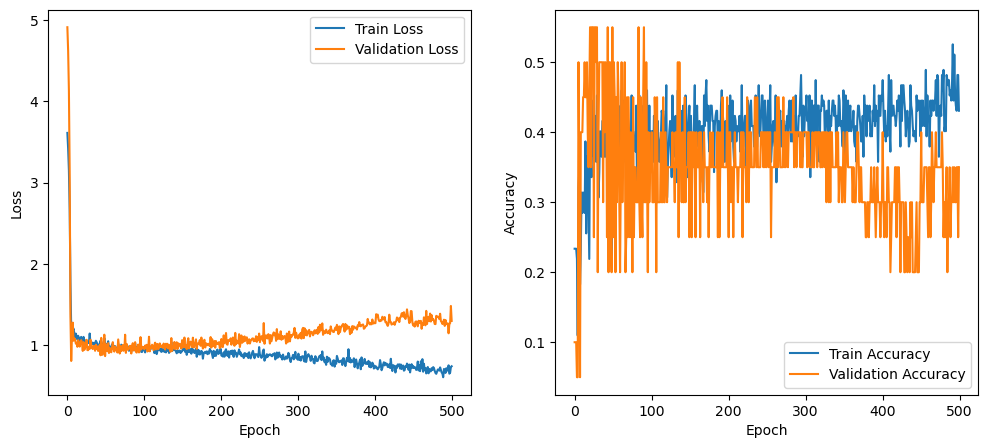

In [ ]:
# Running the training
train_losses, valid_losses = train(model, optimizer, criterion, train_loader, valid_loader, test_loader, n_epochs=500)